<a href="https://colab.research.google.com/github/2019mohamed/ArabDialectClassification/blob/master/SVM_MLP_Boostrap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/two_clo_dialect_dataset.csv')
df

,new_text,label
0,بالنهايه ينتفض يغير,0
1,يعني محسوب البشر حيونه ووحشيه وتطلبون الغرب يح...,0
2,مبين كلامه خليجي,0
3,يسلملي مرورك وروحك الحلوه,0
4,وين الغيبه اخ محمد,0
...,...,...
458192,مبسوطين منك اللي باسطانا,17
458193,والله ماينده ابش يختي,17
458194,شو عملنا حنا تهربي مننا احنا مساكين ليش بتعملي...,17
458195,الله يبارك وبالعافيه,17


In [ ]:
corpus = df['new_text'].astype('str').tolist()
labels = df['label'].tolist()

In [ ]:
def get_index ():
  freqs = df['label'].value_counts()

  start = [0 for _ in range(18)]
  start[0] = 0
  for c in range(1,18):
      start[c] += freqs[c-1] + start[c-1]  
  indexes = []# (mini , maxi+1) for all classes
  for c in range(18):
      indexes.append(  (start[c] , start[c] + freqs[c]) )
    
  return indexes

In [ ]:
import numpy as np

In [ ]:
def sample_data (data , label ,intervals, r = 0.2):
  data = np.array(data)
  label = np.array(label)
  ret = np.array([])
  retl = np.array([])
  for i in range(18):
    l = intervals[i][0]
    h = intervals[i][1]
    index = np.random.choice(range(l,h), size = int((h-l) * r) , replace = False )
    ret = np.concatenate((ret , data[index]), axis = 0)
    retl = np.concatenate((retl , label[index]), axis = 0)

  return ret,retl

In [ ]:
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
vec = pickle.load(open('vectorizer.pkl', 'rb'))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [ ]:
indexes = get_index()

In [ ]:
from scipy.sparse import coo_matrix

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler , BatchSampler
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [ ]:
class MLP(nn.Module):
    """MLP with linear output"""
    def __init__(self, num_layers, input_dim, hidden_dim, output_dim):
        """MLP layers construction
        Paramters
        ---------
        num_layers: int
            The number of linear layers
        input_dim: int
            The dimensionality of input features
        hidden_dim: int
            The dimensionality of hidden units at ALL layers
        output_dim: int
            The number of classes for prediction
        """
        super(MLP, self).__init__()
        self.linear_or_not = True  # default is linear model
        self.num_layers = num_layers
        self.output_dim = output_dim

        if num_layers < 1:
            raise ValueError("number of layers should be positive!")
        elif num_layers == 1:
            # Linear model
            self.linear = nn.Linear(input_dim, output_dim)
        else:
            # Multi-layer model
            self.linear_or_not = False
            self.linears = torch.nn.ModuleList()
            self.batch_norms = torch.nn.ModuleList()

            self.linears.append(nn.Linear(input_dim, hidden_dim))
            for layer in range(num_layers - 2):
                self.linears.append(nn.Linear(hidden_dim, hidden_dim))
            self.linears.append(nn.Linear(hidden_dim, output_dim))

            #for layer in range(num_layers - 1):
             #   self.batch_norms.append(nn.BatchNorm1d((hidden_dim)))

    def forward(self, x):
        if self.linear_or_not:
            # If linear model
            return self.linear(x)
        else:
            # If MLP
            h = x
            for i in range(self.num_layers - 1):
                h = F.relu(self.linears[i](h))
            return self.linears[-1](h)

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [ ]:
def data_classifiy (r = 0.009):
  sample_corpus, sample_label = sample_data(corpus , labels, indexes , r)
  X = vec.transform(sample_corpus)
  X = coo_matrix(X)
  tensor_X = torch.sparse_coo_tensor([X.row , X.col],X.data , dtype = torch.float)
  reducer = MLP(2,tensor_X.shape[1],1000,1000)
  reducer.apply(init_weights)
  Z = reducer(tensor_X)
  Z = Z.detach().numpy()
  permute = np.random.permutation(Z.shape[0])
  Z = Z[permute]
  sample_label = sample_label[permute]
  return Z , sample_label



In [ ]:
from sklearn.svm import SVC

In [ ]:
models = []
N = 5
for i in range(N):
  models.append(SVC(kernel='linear'))

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
predicts = []
ACCs= []
confusion_matrixs = []

In [ ]:
for i in range(N):
  v , l = data_classifiy(0.1)
  X_train, X_test, y_train, y_test = train_test_split(v,l, test_size=0.33, random_state=42)
  models[i].fit(X_train ,y_train)
  predict = models[i].predict(X_test)
  predicts.append(predict)
  ACCs.append(accuracy_score(y_test , predict)*100)
  confusion_matrixs.append(confusion_matrix(y_test , predict, labels = range(0,18)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel pack

In [ ]:
ACCs

[17.548617542002912,
 17.171583542796668,
 17.50892975261278,
 17.601534594523084,
 17.469241963222647]

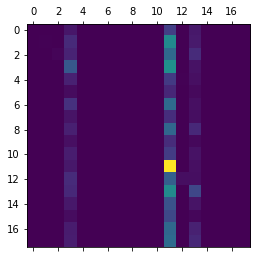

In [ ]:
plt.matshow(confusion_matrixs[3])

In [ ]:
#for i in range(N):
#  pickle.dump(models[i],open('SVM'+str(i)+'.pkl', 'wb'))